In [1]:
import numpy as np
import scipy.linalg as linalg
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import os

In [2]:
def generate_artificial_flow(size,p,T,omega):
    v_x,v_y = np.zeros(size),np.zeros(size);
    for x in range(size[0]):
        for y in range(size[1]):
            A = np.array([[-f,0,x],[0,-f,y]])
            B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
            v_x[x,y],v_y[x,y] = np.dot(A,T)/p[x,y] + np.dot(B,omega)
    return v_x, v_y
    

In [172]:
size = (100,100)
p = np.zeros(size) + 45
p[:,30:40] = p[:,80:90] = 15
p[45:55,45:55] = 30
p[26:39,56:69] = 40
p[53:76,53:76] = 20
T = np.array([[2],[4],[1]])
omega = np.array([[0.15],[0.3],[0.1]])
f = 15

v_x,v_y = generate_artificial_flow(size,p,T,omega)

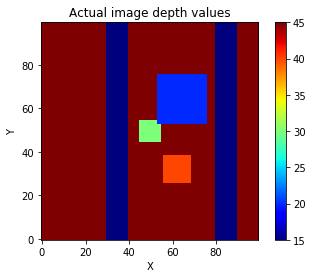

In [173]:
%matplotlib inline
fig = plt.figure('Depth figure')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(p, cmap="jet", origin="lower")
fig.colorbar(im)
ax.set_title('Actual image depth values')
plt.savefig('figs/artificial_depth.png',bbox_inches='tight')

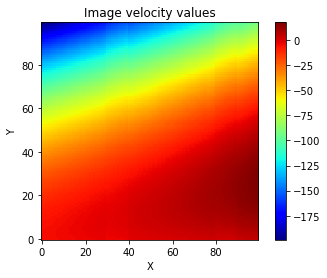

In [174]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(v_x, cmap="jet",origin="lower")
fig.colorbar(im)
ax.set_title('Image velocity values')

# Calculating the estimated translation

## Taking one sample into consideration

In [175]:
x_lim = size[0]
y_lim = size[1]
N = 10 #number of random points
f = 15 #focal length

sample_points = np.transpose([np.random.randint(1,80,size=N),np.random.randint(1,80,size=N)])
sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]

print(sample_v_x, sample_v_y, sample_points)

[-50.08        -6.76555556 -83.65555556 -47.51333333  -1.79333333 -51.4
   2.16222222 -48.03666667  -2.75333333 -32.18111111] [-48.15       -14.63777778 -24.72777778 -16.19222222   8.95666667
 -61.13444444  26.55666667 -34.36666667  -1.95       -14.73555556] [[67 55]
 [41 61]
 [68 16]
 [51 14]
 [ 4 34]
 [75 76]
 [ 4 54]
 [59 35]
 [16 30]
 [43 17]]


In [176]:
def calculate_CT_estimate(sample_points, T): #input the presampled sample points - can be precalculated
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    return np.concatenate((A_T,B),axis=1)

def calculate_q(sample_points, omega, p):
    depths = np.transpose([p[sample_points[:,0],sample_points[:,1]]])
    inv_depths = 1/depths
    return np.vstack((inv_depths,omega))

In [177]:
CT = calculate_CT_estimate(sample_points, T)
q = calculate_q(sample_points,omega,p)
print(np.dot(CT,q))

[[-50.08      ]
 [-48.15      ]
 [ -6.76555556]
 [-14.63777778]
 [-83.65555556]
 [-24.72777778]
 [-47.51333333]
 [-16.19222222]
 [ -1.79333333]
 [  8.95666667]
 [-51.4       ]
 [-61.13444444]
 [  2.16222222]
 [ 26.55666667]
 [-48.03666667]
 [-34.36666667]
 [ -2.75333333]
 [ -1.95      ]
 [-32.18111111]
 [-14.73555556]]


### ^ This is expected because of the reverse engineered values 

We can literally recall because we have a value of the calculated velocities which were generatad from the artificial depth and the image generated from the sequence. 

In [178]:
def sample_T(): #to get a systematic number of T's (use for ||n later)
    for theta in np.arange(0,np.pi,0.01):
        for phi in np.arange(0,np.pi,0.01):
            x = np.cos(theta)*np.sin(phi)
            y = np.sin(theta)*np.sin(phi)
            z = np.cos(phi)
    return np.array([[x],[y],[z]])

def calculate_perp_CT(sample_points, T): #input the presampled sample points - **caution : orth may give errors**
    CT = calculate_CT_estimate(sample_points,T)
    return linalg.orth(CT)

def calculate_ET_perp(sample_points):
    N = np.shape(sample_points)[0];
    search_range = np.arange(0,np.pi,0.01)
    pool = Pool(CPU_NUMBER)
    
    def foo(T):
        return(calculate_perp_CT(sample_points,T))
    
    ET = pool.map(foo,search_range)
    pool.close()
    pool.join()

def calculate_ET_qr(sample_points, T):
    N = np.shape(sample_points)[0];
    CT = calculate_CT_estimate(sample_points,T)
    sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]
    v = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(2*N,1)
    CTbar, r = np.linalg.qr(CT)
    I = np.identity(2*N)
    cc = np.dot(CTbar,np.transpose(CTbar))
    E_T = (np.linalg.norm(np.dot((I - cc),v)))**2
    return E_T
    
    

In [179]:
sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]

In [180]:
%%time
## run through all candidate translation directions
search_range =np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))

for idtheta,theta in enumerate(list(search_range)):
    for idphi,phi in enumerate(list(search_range)):
        x = np.cos(theta)*np.sin(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(phi)
        T = np.array([[x],[y],[z]])

        CT = calculate_CT_estimate(sample_points, T)
        v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) 
        #not sure where I got (-1) from but hey it works #v is concat of all sample point vels 
        v = np.transpose(v_t)
        CTbar, r = np.linalg.qr(CT)
        I = np.identity(2*N)
        cc = np.dot(CTbar,np.transpose(CTbar))
        E_T = (np.linalg.norm(np.dot((I - cc),v)))**2
        E[idtheta,idphi] += E_T

        
idtheta, idphi = np.unravel_index(E.argmin(), E.shape)
theta, phi = search_range[idtheta], search_range[idphi]
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x_final],[y_final],[z_final]])
print(T_final)

[[ 0.43386663]
 [ 0.87395413]
 [ 0.21900669]]
CPU times: user 1min 59s, sys: 1.1 s, total: 2min
Wall time: 30.3 s


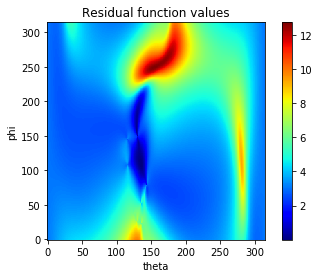

In [181]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Residual function values')

In [182]:
T = T_final
print(T)

[[ 0.43386663]
 [ 0.87395413]
 [ 0.21900669]]


In [189]:
np.array([[2],[4],[1]])/np.sqrt(21)

array([[ 0.43643578],
       [ 0.87287156],
       [ 0.21821789]])

In [183]:
#estimating rotation given the translation

N = np.shape(sample_points)[0]; #justincase
f = 15
sum_left = np.zeros([3,3])
sum_right = np.zeros([3,1])

for time in np.arange(20,21,1):
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]

        #calculating d
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        d = np.array([[AtimesT[1,0]],[-AtimesT[0,0]]])
        di = d/linalg.norm(d)

        #calculating left term in omega estimate
        Bi = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        sum_left += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),Bi)))
        
        #calculating right term in omega estimate
        sample_v_x,sample_v_y = v_x[x,y],v_y[x,y]
        vi = np.array([[sample_v_x],[sample_v_y]])
        sum_right += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),vi)))

omega = np.dot(linalg.inv(sum_left),sum_right)
print(omega)

[[ 0.14996478]
 [ 0.30005179]
 [ 0.09975724]]


In [184]:
#calculating depth
depth_mat0 = np.zeros([x_lim,y_lim])
depth_mat1 = np.zeros([x_lim,y_lim])
for x in np.arange(0,x_lim,1):
    for y in np.arange(0,y_lim,1):
        A = np.array([[-f,0,x],[0,-f,y]])
        B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        v = np.array([[v_x[x,y]],[v_y[x,y]]])
        scaled_AT = v - np.dot(B,omega)
        act_AT = np.dot(A,T)
        depth0 = (act_AT/scaled_AT)[0]
        depth1 = (act_AT/scaled_AT)[1]
        depth_mat0[x,y] = depth0
        depth_mat1[x,y] = depth1


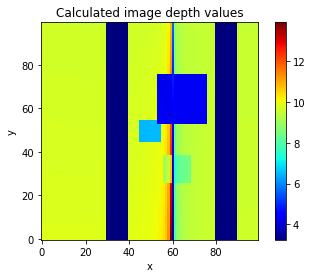

In [191]:
#plotting depth
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.imshow(depth_mat1, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Calculated image depth values')
plt.savefig('figs/calculated_depth.png', bbox_inches='tight')
